In [ ]:
print("Kernal Started")

In [ ]:
!pip install tensorflow==2.10.0

In [ ]:
!pip install numpy==1.24.1

In [ ]:
!pip install Pillow==9.3.0

In [2]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

import google.protobuf

print("Protocol Buffers version:", google.protobuf.__version__)


TensorFlow version: 2.10.0
Keras version: 2.10.0
Protocol Buffers version: 3.19.6


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [4]:
print("Done setup")

Done setup


In [5]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

train_path='/kaggle/input/cinnamon-original/Cinnamon_NoAug/Data/train'
test_path='/kaggle/input/cinnamon-original/Cinnamon_NoAug/Data/test'
valid_path='/kaggle/input/cinnamon-original/Cinnamon_NoAug/Data/valid'

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=True)

valid_set = valid_datagen.flow_from_directory(valid_path,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical',
                                              shuffle=True)

# Set up data
batch_size = 32
img_height = 224
img_width = 224


# Define early stopping and model checkpoint callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('VGG16_2_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

Found 1480 images belonging to 3 classes.
Found 420 images belonging to 3 classes.


In [6]:
# Define the number of classes for your classification task
num_classes = 3

# Define the input size for the EfficientNet model
input_shape = (224, 224, 3)

# Load the pre-trained EfficientNetB0 model and exclude the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global average pooling layer and a dense output layer with softmax activation
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the new model with the EfficientNet base and custom output layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with appropriate loss function, optimizer, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# model.summary()

# Print the original weights of the model
# print("Original Weights:")
# print(model.get_weights())

58889256/58889256 [==============================] - 0s 0us/step


In [7]:
# Train the model
history = model.fit(training_set, 
                              validation_data=valid_set,
                              epochs=10,
                              callbacks=[early_stop, model_checkpoint])

Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.8155
Epoch 1: val_loss improved from inf to 0.71956, saving model to VGG16_2_best.h5
47/47 [==============================] - 445s 9s/step - loss: 0.8906 - accuracy: 0.8155 - val_loss: 0.7196 - val_accuracy: 0.9405
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.9561
Epoch 2: val_loss improved from 0.71956 to 0.52519, saving model to VGG16_2_best.h5
47/47 [==============================] - 403s 9s/step - loss: 0.6056 - accuracy: 0.9561 - val_loss: 0.5252 - val_accuracy: 0.9738
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.9628
Epoch 3: val_loss improved from 0.52519 to 0.41439, saving model to VGG16_2_best.h5
47/47 [==============================] - 413s 9s/step - loss: 0.4553 - accuracy: 0.9628 - val_loss: 0.4144 - val_accuracy: 0.9595
Epoch 4/10
47/47 [==============================] - ETA: 0s - loss: 0.3616 - acc

In [8]:
model.save('VGG16_2.h5')

import pickle
with open('history_VGG16_2.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Evaluate the Model

In [9]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [10]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
test_batches = test_datagen.flow_from_directory(test_path,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

Found 205 images belonging to 3 classes.


In [12]:
score = model.evaluate(test_batches)
print(score)

7/7 [==============================] - 49s 7s/step - loss: 0.1640 - accuracy: 0.9805
[0.1639707386493683, 0.9804878234863281]


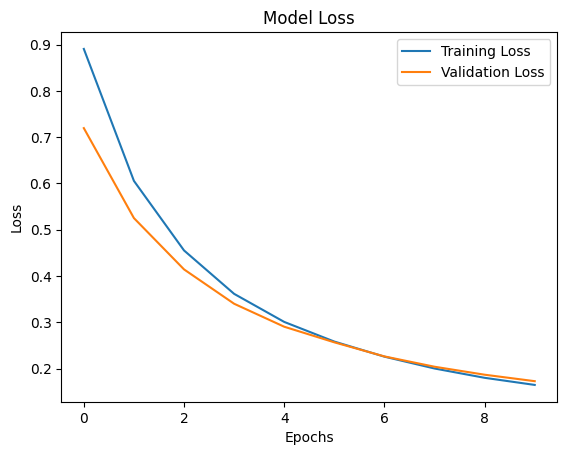

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()


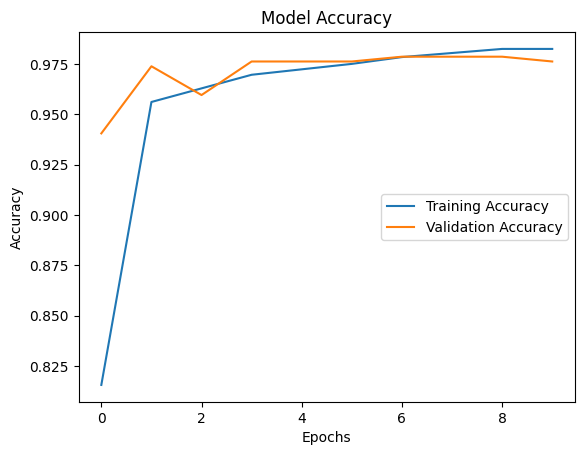

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='center right')
plt.show()


In [15]:
predictions= model.predict(test_batches)

7/7 [==============================] - 45s 6s/step


In [16]:
rounded_prediction = np.argmax(predictions,axis=-1)

In [17]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max()/2.

    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [18]:
cm = confusion_matrix(y_true=test_batches.classes,y_pred=rounded_prediction)

In [19]:
cm_plot_labels=["mite","normal","yellow"]

Confusion matrix, without normalization
[[70  0  0]
 [ 0 69  1]
 [ 0  3 62]]


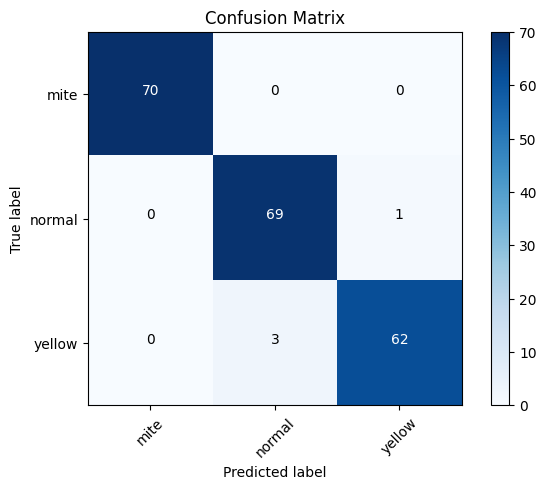

In [20]:
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [21]:
from sklearn.metrics import classification_report

print(classification_report(test_batches.classes,rounded_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       0.96      0.99      0.97        70
           2       0.98      0.95      0.97        65

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205

